### Important librairies

In [9]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Image
from lxml import objectify
import math
import time
#from pytrends.request import TrendReq
from wordcloud import WordCloud
#from ast import literal_eval

#Import data from wikidata.org
#from wikidata2df import wikidata2df

#Convert country name to ISO-3
import country_converter as coco

#World map plot librairies
import plotly.offline as po
import plotly.graph_objs as pg
import plotly.express as px
import plotly.graph_objs as go

# Analysis of the lexical fields
from empath import Empath 

#Warnings
import warnings

data_folder = './data/'

### 2.3.1) Movie summary

In [10]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_character_usa = pd.read_csv('df_character_usa.csv')

decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['Movie_date']>decade[0:3]) & (df_movie_usa['Movie_date']<decade[5:8])].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,0.0,7.0,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge,7
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,2.0,1.0,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles,7
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,1.0,9.0,611.0,6.0,8.0,Greenhill,Haines,M,Don Johnson,6
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
34406,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Drama'],NaN,...,1.0,0.0,118.0,0.0,0.0,NaN,NaN,NaN,NaN,0


In [11]:
#Dataframe with existing movie summary
wiki_id_list = []
for ctr,wiki_id in enumerate(list(df_movie_usa['Wikipedia_movie_ID'])) : 
    path = data_folder+'/corenlp_plot_summaries/'+str(wiki_id)+'.xml'
    if os.path.exists(path):
        wiki_id_list.append(wiki_id)
wiki_id_series = pd.Series(wiki_id_list, name='Wikipedia_movie_ID',dtype=object)

#Data frame (movie metadata) with only existing summaries 
df_movie_usa_summary=df_movie_usa.merge(wiki_id_series, on='Wikipedia_movie_ID')


#Data frame (character metadata) with only existing summaries
df_character_usa_summary=df_character_usa.merge(wiki_id_series, on='Wikipedia_movie_ID')


In [42]:
##### Adjectives and verbs associated to women/men characters ######

#Summary exploration
df=df_movie_usa_summary


#Initialization
dic_he_adj = dict.fromkeys(decades_code,[])
dic_she_adj = dict.fromkeys(decades_code,[])
dic_he_verb = dict.fromkeys(decades_code,[])
dic_she_verb = dict.fromkeys(decades_code,[])


for ctr,decade in enumerate(decades_code):
    he_adj_list, she_adj_list , he_verb_list , she_verb_list = [] , [] , [] , []
    df_dec = df[df.Decade==decade]
    for ctr,movie in enumerate(list(df_dec['Wikipedia_movie_ID'].values)) :

        path = data_folder+'/corenlp_plot_summaries/'+str(movie)+'.xml'
        if os.path.exists(path):
            #Extract dataframe from xml file and convert it into a dataframe
            df_summary=pd.DataFrame()
            df_summary = pd.read_xml(data_folder+'/corenlp_plot_summaries/'+str(movie)+'.xml' , xpath='//token',parser='lxml')
            df_summary.rename(columns={'id':'word_id'},inplace=True)
            df_summary.insert(0, "sentence_id",df_summary['word_id'].ne(df_summary['word_id'].shift()+1).cumsum(), True) #add sentence id by indexing sequences  

            #Identify sentences with he and she
            he_sentences = df_summary[(df_summary.POS=='PRP') & (df_summary.lemma=='he')]['sentence_id'].values
            she_sentences = df_summary[(df_summary.POS=='PRP') & (df_summary.lemma=='she')]['sentence_id'].values
            he_sentences = list(set(he_sentences).difference(she_sentences)) #remove sentences where he and she are present
            she_sentences = list(set(she_sentences).difference(he_sentences)) #remove sentences where he and she are present

            #Identify adjectives and verb associated to he and she
            he_adj , she_adj, he_verb, she_verb = [] , [] , [] , []
            for sent_id in he_sentences:
                df_temp = df_summary[df_summary.sentence_id == sent_id]
                he_adj = df_temp[ (df_temp.POS=='JJ')  ]['lemma'].values
                he_verb = df_temp[df_temp.POS=='VBZ']['lemma'].values
            for sent_id in she_sentences:
                df_temp = df_summary[df_summary.sentence_id == sent_id]
                she_adj = df_temp[ (df_temp.POS=='JJ')  ]['lemma'].values
                she_verb = df_temp[df_temp.POS=='VBZ']['lemma'].values


            he_adj_list.append(list(he_adj))
            she_adj_list.append(list(she_adj))
            he_verb_list.append(list(he_verb))
            she_verb_list.append(list(she_verb))
            
    #Flatten the lists
    he_adj_list = sum(he_adj_list, [])
    she_adj_list = sum(she_adj_list, [])
    he_verb_list = sum(he_verb_list, [])
    she_verb_list = sum(she_verb_list, [])
    
    #Fill dictionnaries of decades
    dic_he_adj[decade] = he_adj_list
    dic_she_adj[decade] = she_adj_list
    dic_he_verb[decade] = he_verb_list
    dic_she_verb[decade] = she_verb_list
    
    
      


In [108]:
he_adj = pd.DataFrame.from_dict(dic_he_adj,orient='index')
she_adj = pd.DataFrame.from_dict(dic_she_adj,orient='index')
he_verb = pd.DataFrame.from_dict(dic_he_verb,orient='index')
she_verb = pd.DataFrame.from_dict(dic_she_verb,orient='index')


In [135]:
from empath import Empath
lexicon = Empath()

df_lex_decade=pd.DataFrame()

for ctr,decade in enumerate(decades):

    he_adj_list = list(filter(lambda item: item is not None, he_adj.iloc[ctr].values))
    she_adj_list = list(filter(lambda item: item is not None, she_adj.iloc[ctr].values))
    he_verb_list = list(filter(lambda item: item is not None, he_verb.iloc[ctr].values))
    she_verb_list = list(filter(lambda item: item is not None, she_verb.iloc[ctr].values))

    #Lexical analaysis
    df_lex=pd.DataFrame()

    dic_lex = lexicon.analyze(he_adj_list, normalize=True)
    s1=pd.Series(dic_lex,name='he_adj')
    dic_lex = lexicon.analyze(she_adj_list, normalize=True)
    s2=pd.Series(dic_lex,name='she_adj')
    dic_lex = lexicon.analyze(he_verb_list, normalize=True)
    s3=pd.Series(dic_lex,name='he_verb')
    dic_lex = lexicon.analyze(she_verb_list, normalize=True)
    s4=pd.Series(dic_lex,name='she_verb')

    df_lex = pd.concat([s1, s2 , s3 , s4],axis=1)
    df_lex['Decade'] = ctr
    
    df_lex_decade =pd.concat([df_lex_decade,df_lex])


In [136]:
df_lex_decade

,he_adj,she_adj,he_verb,she_verb,Decade
help,0.005808,0.007334,0.014991,0.015495,0
office,0.000342,0.000000,0.000366,0.000694,0
dance,0.001708,0.004715,0.001280,0.002081,0
money,0.003758,0.005762,0.004936,0.003469,0
wedding,0.008883,0.013096,0.017916,0.023358,0
...,...,...,...,...,...
rural,0.002914,0.002952,0.001538,0.001648,7
positive_emotion,0.015817,0.014168,0.011279,0.014082,7
musical,0.003746,0.002656,0.003461,0.002697,7
male gaze,0.000000,0.000000,0.000000,0.000000,7


In [151]:
df_lex_decade[df_lex_decade.index=='musical']

,he_adj,she_adj,he_verb,she_verb,Decade
musical,0.002050,0.005762,0.004388,0.005550,0
musical,0.003172,0.005495,0.006723,0.003827,1
musical,0.002780,0.003831,0.003837,0.003540,2
musical,0.001802,0.001520,0.002880,0.001617,3
musical,0.000000,0.001414,0.004255,0.003019,4
musical,0.002065,0.007048,0.003490,0.002468,5
musical,0.001467,0.002121,0.001899,0.002840,6
musical,0.003746,0.002656,0.003461,0.002697,7


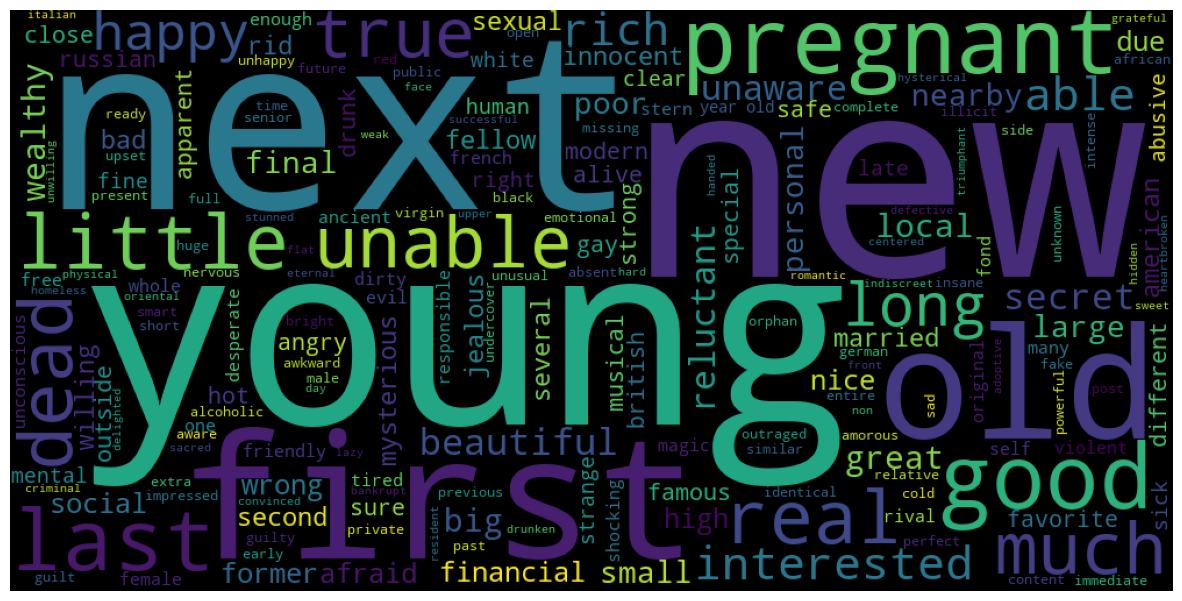

In [79]:
 
text = he_test

#convert list to string and generate
unique_string=(" ").join(text)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

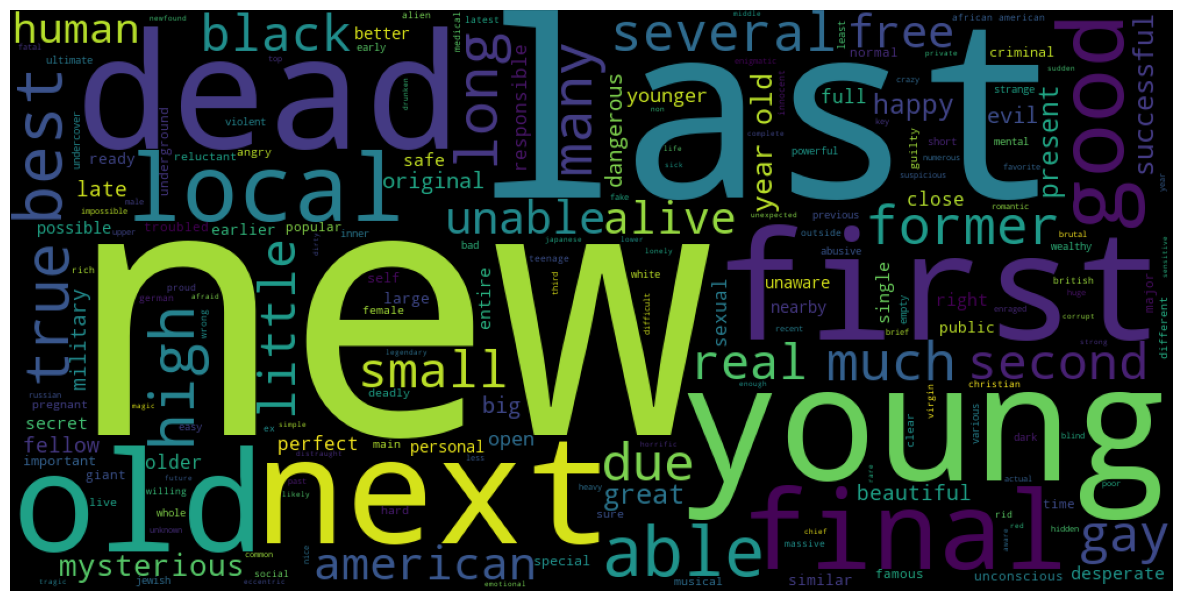

In [37]:
 
text = list(filter(lambda item: item is not None, she_adj.iloc[7].values))

#convert list to string and generate
unique_string=(" ").join(text)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
from top2vec import Top2Vec

text = he_adj.to_list()
model = Top2Vec(text)
topic_words, word_scores, topic_nums = model.get_topics()

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
model.get_num_topics()

NameError: name 'model' is not defined

In [20]:
##### !!! LONG TO RUN ~8min ######

#Summary exploration
df=df_movie_usa_summary

#Initialization
lexicon = Empath()
df_lex_fields = pd.DataFrame()
dic_lex_fields=dict.fromkeys(df['Wikipedia_movie_ID'].values,[])

for ctr,movie in enumerate(list(df['Wikipedia_movie_ID'].values)) :

    path = data_folder+'/corenlp_plot_summaries/'+str(movie)+'.xml'
    if os.path.exists(path):
        #Extract dataframe from xml file and convert it into a dataframe
        df_summary=pd.DataFrame()
        df_summary = pd.read_xml(data_folder+'/corenlp_plot_summaries/'+str(movie)+'.xml' , xpath='//token',parser='lxml')
        df_summary.rename(columns={'id':'word_id'},inplace=True)
        df_summary.insert(0, "sentence_id",df_summary['word_id'].ne(df_summary['word_id'].shift()+1).cumsum(), True) #add sentence id by indexing sequences  
        
        ###Lexical field analysis
        summary_words=list(df_summary['word'].values) #all words of the summary in a list
        summary_words=[str(word) for word in summary_words] #convert all words to a string
        features_lex_fields = pd.Series([lexicon.analyze(list(summary_words), categories = ["feminine","sexist","sexiest","beauty","beautiful","positive_emotion","negative_emotion"])])
        #Store data into a dictionnary
        dic_lex_fields[movie]= features_lex_fields[0]
        #Add a column corresponding to the number of words in the summary
        dic_lex_fields[movie]['Number_of_words']=len(df_summary)
        
        
        
        ###Count of he/she        
        #Filter only the pronouns
        df_summary_pronouns= df_summary[df_summary.POS=='PRP']
        #Count the number of redundant words 
        personal_pronouns = df_summary_pronouns.groupby(['word'])['word'].count().sort_values(ascending=False)

        if 'he' in list(personal_pronouns.index):
            dic_lex_fields[movie]['he_count'] = personal_pronouns['he']
        else:
            dic_lex_fields[movie]['he_count'] = 0

        if 'she' in list(personal_pronouns.index):
            dic_lex_fields[movie]['she_count'] = personal_pronouns['she'] 
        else:
            dic_lex_fields[movie]['she_count'] = 0
        
        
        
        ###Principal characters according to the summary
        characters_name = df_summary[df_summary['NER'] == 'PERSON']['word'].value_counts().index
        if len(characters_name)>=2:
            dic_lex_fields[movie]['Principal_summary_character'] =  characters_name[0] 
            dic_lex_fields[movie]['Secondary_summary_character'] =  characters_name[1] 
        if len(characters_name)==1:
            dic_lex_fields[movie]['Principal_summary_character'] =  characters_name[0] 
            dic_lex_fields[movie]['Secondary_summary_character'] =  float('nan')    
        if len(characters_name)==0:
            dic_lex_fields[movie]['Principal_summary_character'] =  float('nan')
            dic_lex_fields[movie]['Secondary_summary_character'] =  float('nan')   

df_lex_fields = pd.DataFrame.from_dict(dic_lex_fields, orient='index')  
#df_lex_fields.insert(loc=0, column='Movie_name', value=df['Movie_name'].values)
df_lex_fields.insert(loc=1, column='Freebase_movie_ID', value=df['Freebase_movie_ID'].values)
df_usa_summary_processed=df_movie_usa_summary.merge(df_lex_fields, on='Freebase_movie_ID')
df_usa_summary_processed


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score,...,sexiest,beauty,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",22%,...,0.0,0.0,0.0,0.0,7.0,396,1,0,Ballard,Williams
1,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",NaN,...,0.0,0.0,0.0,2.0,2.0,257,2,5,Adam,Kate
2,11250635,/m/02r52hc,The Mechanical Monsters,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Science Fiction, Adventure, Animation, Short ...",NaN,...,0.0,1.0,0.0,0.0,3.0,707,4,2,Lois,Clark
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",NaN,...,0.0,1.0,0.0,8.0,5.0,1678,12,7,Mary,Banks
4,21926710,/m/05p45cv,White on Rice,2009,NaN,82.0,{},[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]",45%,...,0.0,1.0,0.0,2.0,0.0,125,3,0,Jimmy,Tak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20784,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Alien Film, Science Fiction, Family Film, Com...",8%,...,0.0,0.0,0.0,2.0,4.0,639,1,0,Bipto,Wrenchmuller
20785,26044505,/m/0b6m67n,The Flying Serpent,1946,NaN,59.0,{},[United States of America],"[Thriller, B-movie, Horror]",NaN,...,0.0,0.0,0.0,0.0,3.0,37,1,0,Andrew,Forbes
20786,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","[France, United States of America]","[Parody, Americana, Comedy]",85%,...,0.0,0.0,0.0,2.0,1.0,252,1,1,Carla,Walt
20787,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},[United States of America],"[Thriller, Erotic thriller, Psychological thri...",38%,...,0.0,0.0,0.0,1.0,9.0,611,6,8,Greenhill,Haines


In [21]:
#df=df_movie_usa.merge(df_usa_summary_processed, on=['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_date','Movie_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres'], how='outer')
df=df_movie_usa.merge(df_usa_summary_processed, on=['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_date','Movie_revenue','Movie_runtime','Movie_languages'], how='outer')
df.drop('Movie_genres_y', inplace=True, axis=1)
df.drop('Movie_countries_y', inplace=True, axis=1)
df.rename(columns={"Movie_genres_x": "Movie_genres", "Movie_countries_x": "Movie_countries"},inplace=True)

#Export final dataframe for movie metadata
df.to_csv('df_movie_usa.csv',index=False)


In [22]:
##### !!! LONG TO RUN ~15min ######

#Identify if the principal character from summary is a men or a women?
df1=pd.read_csv('df_movie_usa.csv')
df2=pd.read_csv('df_character_usa.csv')
sex,principal_actor_name_list=[],[]
for ctr,movie_id in enumerate(df1['Freebase_movie_ID']):
    #All characters of the movie
    characters_serie=df2[df2.Freebase_movie_ID== movie_id]['Character_name']
    characters=df2[df2.Freebase_movie_ID== movie_id ]['Character_name'].values
    characters=[str(word) for word in characters] #convert all words to a string

    #Principal character of the movie (from the summary)
    principal_character=df1[df1.Freebase_movie_ID== movie_id]['Principal_summary_character'].values[0]
    principal_character=str(principal_character)

    if (principal_character== 'nan') or (principal_character== 'Nan') or (principal_character== 'NaN'):
        character_sex = float('nan')
        principal_actor_name = float('nan')
        sex.append(character_sex) #nan is assigned when no principal character is found
        principal_actor_name_list.append(principal_actor_name) #nan is assigned when no principal character is found
    
    else:
        for ctr,char in enumerate(characters):
            character_sex= float('nan')
            if principal_character.lower() in char.lower():
                index_character= characters_serie[characters_serie==char].index[0] #index of the matched character
                principal_actor_name = df2.iloc[index_character]['Actor_name'] #the name of the actor of the matched character is assigned
                character_sex= df2.iloc[index_character]['Actor_gender']  #the sex of the matched character is assigned
                break
        sex.append(character_sex)
        principal_actor_name_list.append(principal_actor_name)

df1['Principal_character_sex']=sex
df1['Principal_character_actor']=principal_actor_name_list

df1.to_csv('df_movie_usa.csv',index=False)

#### Import CSV

In [65]:
df_movie_usa=pd.read_csv('df_movie_usa.csv')
df_character_usa=pd.read_csv('df_character_usa.csv')